In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
af_path_old = '/home/greg/sftp/eddyflux/Ameriflux_files/'

import os
import load_nmeg as ld
import transform_nmeg as tr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

In [5]:
# Read Laura's data in

path = "/home/greg/Desktop/FINAL_DATABASIS/"
pjc_laura = pd.read_csv( path + "PJC_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_laura = pd.read_csv( path + "PJG_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')
pjc_lauraftp = pd.read_csv( path + "PJC_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_lauraftp = pd.read_csv( path + "PJG_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')

In [2]:
# Get Greg's data
# Years to load
starty = 2009
endy = 2013
# Sites to load
sites = ['Mpj', 'Mpg']

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=starty, endyear=endy) 
          for x in sites }

hourly_old = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path_old, gapfilled=True, startyear=starty, endyear=endy,
                              old_dparse=True) 
          for x in sites }

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/US-Mpj

In [3]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
# Uses the old way of calculating ET (daily sum)
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }
# This is the newer method of calculating ET (daytime based)
et_daymethod = { x : 
                tr.get_daytime_et_pet( hourly[x], freq='1D',
                                le_col='LE_F', tair_col='TA_F', sw_col='SW_IN_F' ) 
                for x in hourly.keys() }

# Convert these to a pandas panel
d = pd.Panel(daily)
et_dly = pd.Panel(et_daymethod)


## Compare ET and P

In [6]:
# ET
df_ET = pd.DataFrame( index = np.asarray(range(starty, endy)))
df_ET_day = pd.DataFrame( index = np.asarray(range(starty, endy)))
df_P = pd.DataFrame( index = np.asarray(range(starty, endy)))

gby = d.Mpg.ET_mm_fullday_0.groupby(d.Mpg.index.year)
df_ET['Girdle ET(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_fullday_0.groupby(d.Mpj.index.year)
df_ET['Control ET(Greg)'] = gby.sum()
gby = pjg_laura.ET.groupby(pjg_laura.index.year)
df_ET['Girdle ET(Laura)'] = gby.sum()
gby = pjc_laura.ET.groupby(pjc_laura.index.year)
df_ET['Control ET(Laura)'] = gby.sum()

gby = et_dly.Mpg.ET_mm_daytime.groupby(d.Mpg.index.year)
df_ET_day['Girdle et_day(Greg)'] = gby.sum()
gby = et_dly.Mpj.ET_mm_daytime.groupby(d.Mpj.index.year)
df_ET_day['Control et_day(Greg)'] = gby.sum()
gby = pjg_laura.ET_Dayt.groupby(pjg_laura.index.year)
df_ET_day['Girdle ET_Dayt(Laura)'] = gby.sum()
gby = pjc_laura.ET_Dayt.groupby(pjc_laura.index.year)
df_ET_day['Control ET_Dayt(Laura)'] = gby.sum()

In [7]:
# This is summed raw ET numbers from Laura and Greg's data
df_ET

,Girdle ET(Greg),Control ET(Greg),Girdle ET(Laura),Control ET(Laura)
2009,366.754755,318.538314,374.166232,320.486766
2010,392.691369,408.225685,392.321345,404.886621
2011,256.489166,279.035585,256.110038,281.656078
2012,264.297262,301.488548,251.740634,300.457563


In [8]:
# This is ET calculated on a daily basis from daytime LE/Tair values only (SW_IN > 5)
df_ET_day

,Girdle et_day(Greg),Control et_day(Greg),Girdle ET_Dayt(Laura),Control ET_Dayt(Laura)
2009,339.515282,302.850970,346.796318,307.329569
2010,374.076268,388.321741,374.948771,387.112575
2011,245.723329,268.618087,245.743733,271.108398
2012,248.185403,291.516176,233.097157,291.429758


In [9]:
# Precip
gby = d.Mpg.P_F.groupby(d.Mpg.index.year)
df_P['Girdle Precip (Greg)'] = gby.sum()
gby = d.Mpj.P_F.groupby(d.Mpj.index.year)
df_P['Control Precip(Greg)'] = gby.sum()
gby = pjg_laura.PRECIP.groupby(pjg_laura.index.year)
df_P['Girdle Precip(Laura)'] = gby.sum()
gby = pjc_laura.PRECIP.groupby(pjc_laura.index.year)
df_P['Control Precip(Laura)'] = gby.sum()

df_P

,Girdle Precip (Greg),Control Precip(Greg),Girdle Precip(Laura),Control Precip(Laura)
2009,322.93017,329.45052,297.942,329.200000
2010,347.98000,328.92627,347.980,328.926008
2011,255.77800,273.80000,255.778,273.600000
2012,157.24000,180.30000,151.892,165.500000


## Plot comparisons for control

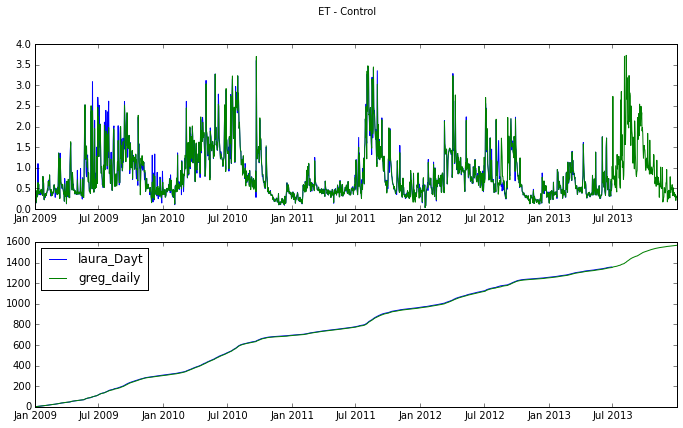

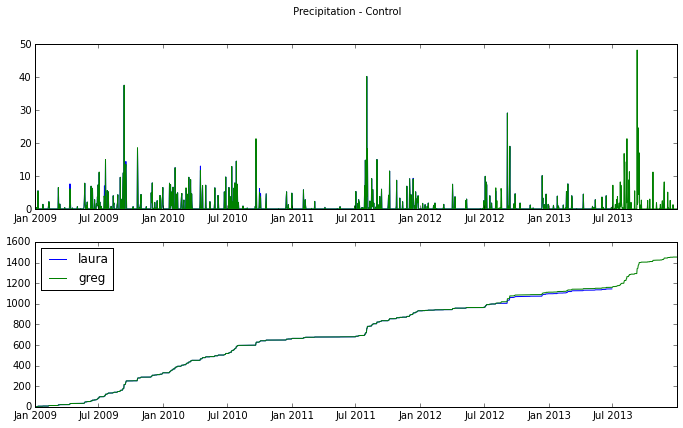

In [10]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_laura.index, pjc_laura.ET_Dayt)
#plt.plot(pjc_laura.index, pjc_laura.ET)
plt.plot(et_dly.Mpj.index, et_dly.Mpj.ET_mm_daytime)
#plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_laura.index, pjc_laura.ET_Dayt.cumsum())
#plt.plot(pjc_laura.index, pjc_laura.ET.cumsum())
plt.plot(et_dly.Mpj.index, et_dly.Mpj.ET_mm_daytime.cumsum())
#plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0.cumsum())
plt.legend(['laura_Dayt', 'greg_daily'], loc='upper left')
plt.suptitle(' ET - Control')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_laura.index, pjc_laura.PRECIP)
plt.plot(d.Mpj.index, d.Mpj.P_F)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_laura.index, pjc_laura.PRECIP.cumsum())
plt.plot(d.Mpj.index, d.Mpj.P_F.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Control')
plt.show()

## Plot comparisons for girdle

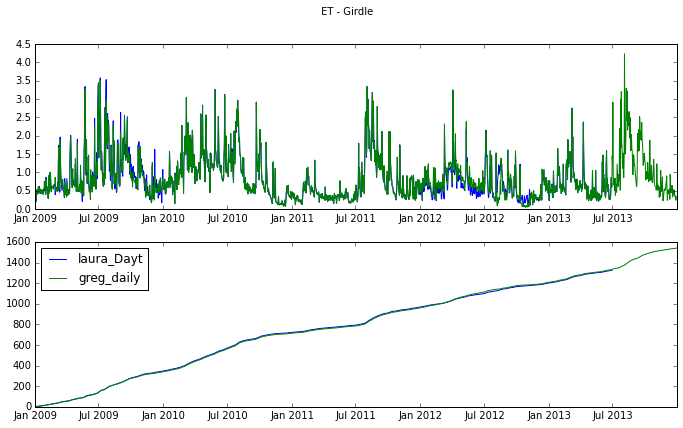

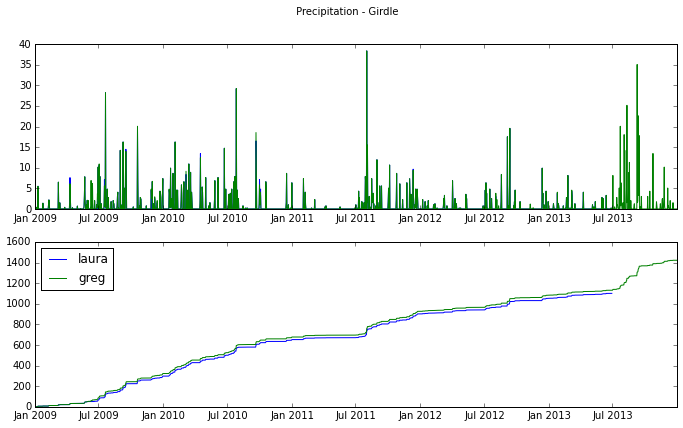

In [11]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_laura.index, pjg_laura.ET_Dayt)
#plt.plot(pjg_laura.index, pjg_laura.ET)
plt.plot(et_dly.Mpg.index, et_dly.Mpg.ET_mm_daytime)
#plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_laura.index, pjg_laura.ET_Dayt.cumsum())
#plt.plot(pjg_laura.index, pjg_laura.ET.cumsum())
plt.plot(et_dly.Mpg.index, et_dly.Mpg.ET_mm_daytime.cumsum())
#plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0.cumsum())
plt.legend(['laura_Dayt', 'greg_daily'], loc='upper left')
plt.suptitle(' ET - Girdle')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_laura.index, pjg_laura.PRECIP)
plt.plot(d.Mpg.index, d.Mpg.P_F)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_laura.index, pjg_laura.PRECIP.cumsum())
plt.plot(d.Mpg.index, d.Mpg.P_F.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Girdle')
plt.show()

## Gapfilling

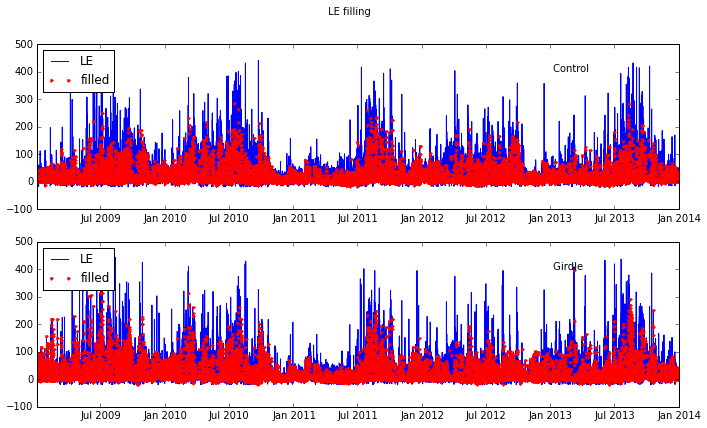

In [12]:
# LE - recent files
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(hourly['Mpj'].index, hourly['Mpj'].LE_F)
test = hourly['Mpj'].LE_F_FLAG==1
plt.plot(hourly['Mpj'].index[test], hourly['Mpj'].loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Control ')
plt.suptitle(' LE filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(hourly['Mpg'].index, hourly['Mpg'].LE_F)
test = hourly['Mpg'].LE_F_FLAG==1
plt.plot(hourly['Mpg'].index[test], hourly['Mpg'].loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Girdle ')
plt.show()

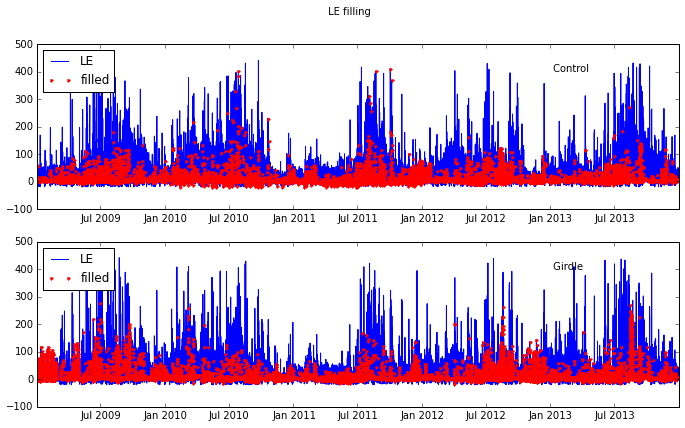

In [13]:
# LE - previous AF files
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(hourly_old['Mpj'].index, hourly_old['Mpj'].LE)
test = hourly_old['Mpj'].LE_flag==1
plt.plot(hourly_old['Mpj'].index[test], hourly_old['Mpj'].loc[test, 'LE'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Control ')
plt.suptitle(' LE filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(hourly_old['Mpg'].index, hourly_old['Mpg'].LE)
test = hourly_old['Mpg'].LE_flag==1
plt.plot(hourly_old['Mpg'].index[test], hourly_old['Mpg'].loc[test, 'LE'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Girdle ')
plt.show()

### Percent LE gapfilled

In [17]:
df = pd.DataFrame()
gby = hourly['Mpj'].LE_F_FLAG.groupby(hourly['Mpj'].index.year)
df['Mpj %gf'] = gby.sum() / gby.count()
gby = hourly['Mpg'].LE_F_FLAG.groupby(hourly['Mpg'].index.year)
df['Mpg %gf'] = gby.sum() / gby.count()
#gby = hourly_old['Mpj'].LE_flag.groupby(hourly_old['Mpj'].index.year)
#df['Mpj_old'] = gby.sum() / gby.count()
#gby = hourly_old['Mpg'].LE_flag.groupby(hourly_old['Mpg'].index.year)
#df['Mpg_old'] = gby.sum() / gby.count()

### Nighttime LE gapfilling

(87648, 33)
(44138, 33)
(87648, 33)
(43992, 33)


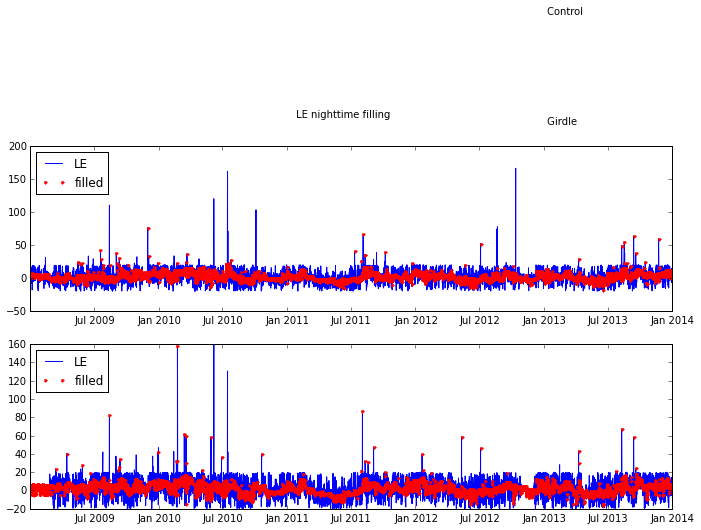

In [15]:
# Extract nighttime data into new dataframes and plot
print(hourly['Mpj'].shape)
pj_night_test = np.logical_or(hourly['Mpj'].PAR < 20, hourly['Mpj'].SW_IN_F < (20*.48))
pj_night = hourly['Mpj'].loc[pj_night_test]
print(pj_night.shape)
print(hourly['Mpg'].shape)
pjg_night_test = np.logical_or(hourly['Mpg'].PAR < 20, hourly['Mpg'].SW_IN_F < (20*.48))
pjg_night = hourly['Mpg'].loc[pjg_night_test]
print(pjg_night.shape)

# LE - recent files
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pj_night.index, pj_night.LE_F)
test = pj_night.LE_F_FLAG==1
plt.plot(pj_night.index[test], pj_night.loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Control ')
plt.suptitle(' LE nighttime filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_night.index, pjg_night.LE_F)
test = pjg_night.LE_F_FLAG==1
plt.plot(pjg_night.index[test], pjg_night.loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Girdle ')
plt.show()

In [16]:
# Put nighttime values in table
gby = pj_night.LE_F.groupby(pj_night.index.year)
df['Mpj night Avg val'] = gby.mean()
gby_g = pjg_night.LE_F.groupby(pjg_night.index.year)
df['Mpg night Avg val'] = gby_g.mean()
df['Mpj night max val'] = gby.max()
df['Mpg night min val'] = gby_g.min()

# Calculate percentage of night values gapfilled
gby = pj_night.LE_F_FLAG.groupby(pj_night.index.year)
df['Mpj night %gf'] = gby.sum() / gby.count()
gby_g = pjg_night.LE_F_FLAG.groupby(pjg_night.index.year)
df['Mpg night %gf'] = gby_g.sum() / gby_g.count()

# Now get gapfilled only values
print(pj_night.shape)
pj_night_gf_test = pj_night.LE_F_FLAG > 0
pj_night_gf = pj_night.loc[pj_night_gf_test]
print(pj_night_gf.shape)
print(pjg_night.shape)
pjg_night_gf_test = pjg_night.LE_F_FLAG > 0
pjg_night_gf = pjg_night.loc[pjg_night_gf_test]
print(pjg_night_gf.shape)

gby = pj_night_gf.LE_F.groupby(pj_night_gf.index.year)
df['Mpj night gf mean'] = gby.mean()
gby_g = pjg_night_gf.LE_F.groupby(pjg_night_gf.index.year)
df['Mpg night gf mean'] = gby_g.mean()

df

(44138, 33)
(16858, 33)
(43992, 33)
(16661, 33)


,Mpj %gf,Mpg %gf,Mpj night Avg val,Mpg night Avg val,Mpj night max val,Mpg night min val,Mpj night %gf,Mpg night %gf,Mpj night gf mean,Mpg night gf mean
2009,0.279982,0.431303,2.524636,4.299022,110.61041,-19.93622,0.362660,0.496702,2.793666,3.983743
2010,0.301884,0.271290,3.139156,2.975586,161.54726,-19.97381,0.387894,0.334586,3.839376,4.028447
2011,0.305080,0.277454,1.664605,1.724564,65.99277,-19.82154,0.383813,0.318316,2.896803,3.365176
2012,0.295025,0.356273,1.574544,2.544219,166.35973,-19.99265,0.367927,0.385104,1.420400,2.155406
2013,0.303995,0.296861,3.054555,2.710745,63.81010,-19.88651,0.407420,0.358782,3.285458,3.213909
2014,1.000000,1.000000,2.246150,3.053820,2.24615,3.05382,1.000000,1.000000,2.246150,3.053820


### Examine nighttime, daytime, gapfilling uncertainty

In [18]:
eddyproc_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/'
pjc_unc = ld.get_multiyr_eddyproc('Mpj', eddyproc_path, 2009, 2012)
pjg_unc = ld.get_multiyr_eddyproc('Mpg', eddyproc_path, 2009, 2012)

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2009.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2010.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2011.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2012.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2009.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2010.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2011.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2012.txt


In [45]:
hourly_unc = hourly.copy()
hourly_unc['Mpj'] = hourly_unc['Mpj'].join(pjc_unc.LE_fs_unc) 
hourly_unc['Mpg'] = hourly_unc['Mpg'].join(pjg_unc.LE_fs_unc)

# Empty dataframe for ET_unc values
df_unc = pd.DataFrame()

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_unc.keys() }
# Mean uncertainty
gby = daily_unc['Mpj'].ET_mm_fullday_1.groupby(daily_unc['Mpj'].index.year)
df_unc['Mpj sum unc'] = gby.sum()
gby = daily_unc['Mpg'].ET_mm_fullday_1.groupby(daily_unc['Mpg'].index.year)
df_unc['Mpg sum unc']  = gby.sum()

In [46]:
# Get night/day values
hourly_night_unc = hourly_unc.copy();
hourly_day_unc = hourly_unc.copy();
pj_night_test = np.logical_or(hourly_unc['Mpj'].PAR < 20, hourly_unc['Mpj'].SW_IN_F < (20*.48))
pjg_night_test = np.logical_or(hourly_unc['Mpg'].PAR < 20, hourly_unc['Mpg'].SW_IN_F < (20*.48))
hourly_night_unc['Mpj'] = hourly_night_unc['Mpj'].loc[pj_night_test]
hourly_night_unc['Mpg'] = hourly_night_unc['Mpg'].loc[pjg_night_test]
hourly_day_unc['Mpj'] = hourly_day_unc['Mpj'].loc[~pj_night_test]
hourly_day_unc['Mpg'] = hourly_day_unc['Mpg'].loc[~pjg_night_test]

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_day_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_day_unc.keys() }

gby = daily_unc['Mpj'].ET_mm_fullday_1.groupby(daily_unc['Mpj'].index.year)
df_unc['Mpj sum unc - day'] = gby.sum()
gby = daily_unc['Mpg'].ET_mm_fullday_1.groupby(daily_unc['Mpg'].index.year)
df_unc['Mpg sum unc - day']  = gby.sum()

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_night_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_night_unc.keys() }

gby = daily_unc['Mpj'].ET_mm_fullday_1.groupby(daily_unc['Mpj'].index.year)
df_unc['Mpj sum unc - night'] = gby.sum()
gby = daily_unc['Mpg'].ET_mm_fullday_1.groupby(daily_unc['Mpg'].index.year)
df_unc['Mpg sum unc - night']  = gby.sum()

In [47]:
# Now get gapfilled only values
hourly_night_gf_unc = hourly_night_unc.copy();
hourly_day_gf_unc = hourly_day_unc.copy();
pj_night_gf_test = hourly_night_unc['Mpj'].LE_F_FLAG > 0
pjg_night_gf_test = hourly_night_unc['Mpg'].LE_F_FLAG > 0
hourly_night_gf_unc['Mpj'] = hourly_night_gf_unc['Mpj'].loc[pj_night_gf_test]
hourly_night_gf_unc['Mpg'] = hourly_night_gf_unc['Mpg'].loc[pjg_night_gf_test]
pj_day_gf_test = hourly_day_unc['Mpj'].LE_F_FLAG > 0
pjg_day_gf_test = hourly_day_unc['Mpg'].LE_F_FLAG > 0
hourly_day_gf_unc['Mpj'] = hourly_day_gf_unc['Mpj'].loc[pj_day_gf_test]
hourly_day_gf_unc['Mpg'] = hourly_day_gf_unc['Mpg'].loc[pjg_day_gf_test]



daily_unc = { x : 
         tr.resample_30min_aflx( hourly_day_gf_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_day_gf_unc.keys() }

gby = daily_unc['Mpj'].ET_mm_fullday_1.groupby(daily_unc['Mpj'].index.year)
df_unc['Mpj sum gf unc - day'] = gby.sum()
gby = daily_unc['Mpg'].ET_mm_fullday_1.groupby(daily_unc['Mpg'].index.year)
df_unc['Mpg sum gf unc - day']  = gby.sum()

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_night_gf_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_night_gf_unc.keys() }

gby = daily_unc['Mpj'].ET_mm_fullday_1.groupby(daily_unc['Mpj'].index.year)
df_unc['Mpj sum gf unc - night'] = gby.sum()
gby = daily_unc['Mpg'].ET_mm_fullday_1.groupby(daily_unc['Mpg'].index.year)
df_unc['Mpg sum gf unc - night']  = gby.sum()

df_unc

,Mpj sum unc,Mpg sum unc,Mpj sum unc - day,Mpg sum unc - day,Mpj sum unc - night,Mpg sum unc - night,Mpj sum gf unc - day,Mpg sum gf unc - day,Mpj sum gf unc - night,Mpg sum gf unc - night
2009,194.869606,234.015685,155.201575,195.182770,39.668031,38.832915,33.245806,68.960907,15.781051,18.344201
2010,220.529985,228.052309,177.155385,185.019289,43.374600,43.033020,38.320450,39.022294,18.700660,15.572042
2011,167.944216,171.379450,131.930660,135.913839,36.013556,35.465611,32.540741,35.625173,15.396340,12.669520
2012,179.863643,187.791389,143.721939,149.775667,36.141704,38.015722,34.115594,51.029010,13.587151,15.078968
2013,0.004118,0.005712,NaN,NaN,0.004118,0.005712,NaN,NaN,0.004118,0.005712
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

# Precip
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(hourly['Mpj'].index, hourly['Mpj'].P_F)
test = hourly['Mpj'].P_F_FLAG==1
plt.plot(hourly['Mpj'].index[test], hourly['Mpj'].loc[test, 'P_F'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 20, ' Control ')
plt.suptitle(' Precip filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(hourly['Mpg'].index, hourly['Mpg'].P_F)
test = hourly['Mpg'].P_F_FLAG==1
plt.plot(hourly['Mpg'].index[test], hourly['Mpg'].loc[test, 'P_F'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 15, ' Girdle ')
plt.show()

### Percent Precip gapfilled

In [ ]:
df = pd.DataFrame()
gby = hourly['Mpj'].P_F_FLAG.groupby(hourly['Mpj'].index.year)
df['Mpj'] = gby.sum() / gby.count()
gby = hourly['Mpg'].P_F_FLAG.groupby(hourly['Mpg'].index.year)
df['Mpg'] = gby.sum() / gby.count()
df

## Substitute PRISM precip

In [ ]:
prism_path = '/home/greg/sftp/eddyflux/Ancillary_met_data/PRISM_daily/'
prism_daily = pd.DataFrame()
site_file_list = os.listdir( prism_path )
#newidx = pd.date_range(str( startyear ) + '-01-01 00:30:00',
#                       str( endyear + 1 ) + '-01-01 00:00:00', freq = '30T')
for j in range(starty, endy + 1):
        fName = 'PRISM_DailyPrecip_{0}.csv'.format( str(j) )
        # If theres is a file for that year, load it
        if fName in site_file_list:
            # Call load_aflx_file
            year_df = pd.read_csv( prism_path + fName, index_col='date' )
            # And append to site_df
            prism_daily = prism_daily.append( year_df )
        else:
            print( 'WARNING: ' + fName + ' is missing')
prism_daily.loc[dt.date(2014, 1, 1), :] = np.nan
prism_daily.tail()

In [ ]:
# Find days that have any gapfilled precip
gby = hourly['Mpj'].P_F_FLAG.groupby([hourly['Mpj'].index.year, hourly['Mpj'].index.dayofyear])
test_Mpj = gby.sum() > 0
test_Mpj = test_Mpj.values # Discard index

gby = hourly['Mpg'].P_F_FLAG.groupby([hourly['Mpg'].index.year, hourly['Mpg'].index.dayofyear])
test_Mpg = gby.sum() > 0
test_Mpg = test_Mpg.values # Discard index
# Test that these are the correct length
len(test_Mpg) == len(et_dly.Mpg.LE_F) and len(test_Mpj) == len(et_dly.Mpj.LE_F)

In [ ]:
# Add precip and replace gapfilled periods with PRISM
et_dly.Mpj['P_F_PRISM'] = d.Mpj.P_F
et_dly.Mpg['P_F_PRISM'] = d.Mpg.P_F
et_dly.Mpj['P_F_FLAG'] = test_Mpj
et_dly.Mpg['P_F_FLAG'] = test_Mpg

et_dly.Mpj.loc[test_Mpj, 'P_F_PRISM'] = prism_daily['US-Mpj'][test_Mpj].values
et_dly.Mpg.loc[test_Mpg, 'P_F_PRISM'] = prism_daily['US-Mpg'][test_Mpg].values

#Export for laura
et_dly.Mpj.to_csv('processed_data/Mpj_daily_daytime_ET_PRISM.csv')
et_dly.Mpg.to_csv('processed_data/Mpg_daily_daytime_ET_PRISM.csv')

In [ ]:
# Precip - filled with PRISM
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(et_dly.Mpj.index, et_dly.Mpj.P_F_PRISM)
test = et_dly.Mpj.P_F_FLAG==True
plt.plot(et_dly.Mpj.index[test], et_dly.Mpj.loc[test, 'P_F_PRISM'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 20, ' Control ')
plt.suptitle(' Precip filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(et_dly.Mpg.index, et_dly.Mpg.P_F_PRISM)
test = et_dly.Mpg.P_F_FLAG==1
plt.plot(et_dly.Mpg.index[test], et_dly.Mpg.loc[test, 'P_F_PRISM'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled by prism'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 15, ' Girdle ')
plt.show()

# Add new PRISM precip columns to table
gby = et_dly.Mpg.P_F_PRISM.groupby(et_dly.Mpg.index.year)
df_P['Girdle Precip(Greg - PRISM)'] = gby.sum()
gby = et_dly.Mpj.P_F_PRISM.groupby(et_dly.Mpj.index.year)
df_P['Control Precip(Greg - PRISM)'] = gby.sum()
df_P